In [1]:
## plot within the notebook
%matplotlib inline
import warnings
import numpy as np
## No annoying warnings
warnings.filterwarnings('ignore')

In [2]:
from astrobject.utils.plot.skybins import SurveyFieldBins
ztf_fields = np.genfromtxt('data/ZTF_Fields.txt', comments='%')
bins = SurveyFieldBins(ra=ztf_fields[:,1], dec=ztf_fields[:,2])
# Fields are defined by their midpoints
# Default width and height are set to 7 degrees for now
# There is more field overlap the closer you get to the poles (no surprise)

In [3]:
# Make a mock survey plan (by no means realistic, just trying to capture the effect of
# moving the observed part of the sky along according to the seasons)
import astrobject.simulation as simul
obs_days = np.arange(58000, 58181, 1)

dec_range = [-20, 60]
ra_range = [0, 90]
ra_shift = 360. / 365.25

t_obs = 60.
t_night = 8. * 3600

obs = {'time': [], 'field': [], 'band': [], 'skynoise': []}
for d in obs_days:
    # Find fields that have their center within dec_range and in ra_range shifted by ra_shift for each day
    field_idx = np.where((bins.ra > ra_range[0] + ra_shift * (d - obs_days[0])) &
                         (bins.ra < ra_range[1] + ra_shift * (d - obs_days[0])) &
                         (bins.dec > dec_range[0]) & (bins.dec < dec_range[1]))[0]
    
    # Sort first by ra then by dec
    field_idx = field_idx[np.argsort(bins.ra[field_idx])]
    field_idx = field_idx[np.argsort(bins.dec[field_idx])]

    for k, t in enumerate(np.arange(0, t_night, t_obs)):
        obs['time'].append(d + t / 86400.)
        obs['field'].append(field_idx[k % len(field_idx)])
        obs['band'].append(['desr', 'desg'][(k / len(field_idx)) % 2])
        obs['skynoise'].append(150.) # TBD later, completely random number for now
        
plan = simul.SurveyPlan(time=obs['time'], band=obs['band'], obs_field=obs['field'],
                        skynoise=obs['skynoise'],
                        fields=dict(ra=ztf_fields[:,1], dec=ztf_fields[:,2]))

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f75d0609f10>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7f75ce5e1250>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f75ce7bed90>,
 'figure': <matplotlib.figure.Figure at 0x7f75d06096d0>}

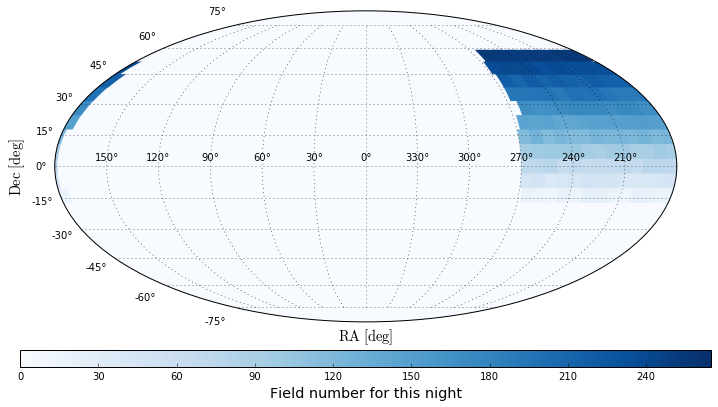

In [4]:
# Example of selected fields (last of the nights in the mock survey)
# The fields are number by the order in which they are observed.
vals = np.zeros(bins.nbins)
for k,l in enumerate(field_idx):
    vals[l] = k
    
bins.imshow(vals, cblabel="Field number for this night")

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f75ce4b5c50>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7f75ccbb0810>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f75ce638b10>,
 'figure': <matplotlib.figure.Figure at 0x7f75ce610dd0>}

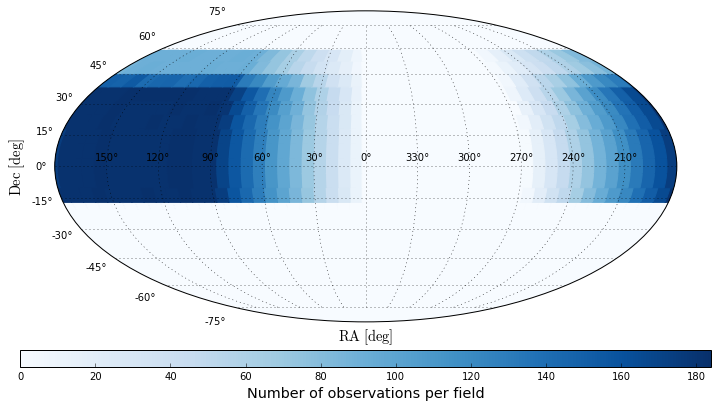

In [5]:
# Number of pointings per field
vals, _ = np.histogram(obs['field'], bins=range(bins.nbins + 1))
bins.imshow(vals, cblabel="Number of observations per field")

In [6]:
tr = simul.sn_generator([0.01,0.1], ratekind="basic", 
                        mjd_range=[obs_days[0] - 60, obs_days[-1] + 25])
# ratekind is the rate of the transient: basiclow = 1e3 
# -> comoving volumetric rate at each redshift in units of yr^-1 Mpc^-3.
# type_ is the type of transient. 
# This will parse the ratekind+type_ do get the good rate function

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f75ccb20250>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7f75cc9357d0>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f75ccb64890>,
 'figure': <matplotlib.figure.Figure at 0x7f75d06095d0>}

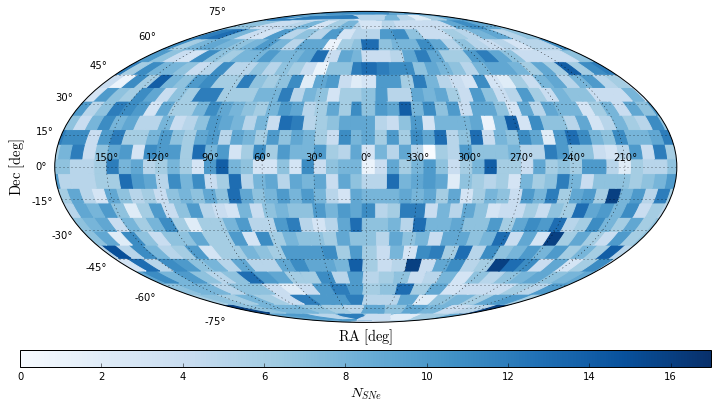

In [7]:
tr.hist_skycoverage(bins=bins)
# Since the fields can overlap, some SNe will be counted twice
# Overlapping fields partly obscure previously drawn 
# Some distortions when drawing fields near the poles (to be fixed later)

SNe observed: 1541 out of 6281


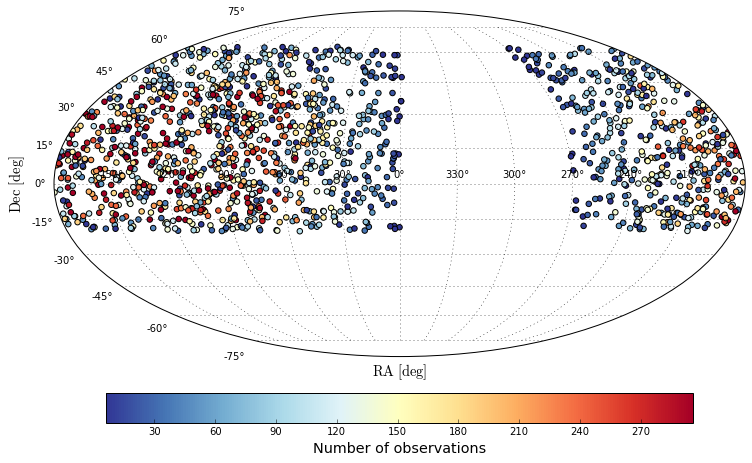

In [8]:
# SimulSurvey class collects all required components, Transient generator, survey plan and instruments
instprop = {"desg":{"gain":1,"zp":30,"zpsys":'ab'},
            "desr":{"gain":1,"zp":30,"zpsys":'ab'}}

survey = simul.SimulSurvey(generator=tr, plan=plan, instprop=instprop)

# Generate the lightcurves. This first determines the dates on which each transient was observed
# to keep the number of lightcurve points that are calculated to a minimum
lcs = survey.get_lightcurves()
n_obs = np.array([len(a) for a in survey.plan.observed])
survey.generator.show_skycoverage(cscale=n_obs, cblabel="Number of observations", mask=(n_obs > 0))
print 'SNe observed: %i out of %i'%(np.sum(n_obs > 0), survey.generator.ntransient)

In [27]:
lcs[30:40]

[None, None, <Table masked=False length=276>
      time       band        flux        fluxerr      zp   zpsys  
    float64    string32    float64       float64    int64 string16
 ------------- -------- ------------- ------------- ----- --------
 58092.1111111     desr -15.825148267 150.000642385    30       ab
 58092.1194444     desr 258.600117976 150.000064938    30       ab
 58092.2930556     desg    296.158336 150.029638028    30       ab
 58092.3013889     desg 1.32693462249 150.032009035    30       ab
 58093.1111111     desr 363.320753924 150.716658732    30       ab
 58093.1194444     desr 59.5767938802 150.728100729    30       ab
 58093.2930556     desg 250.708075646 150.918833133    30       ab
 58093.3013889     desg 409.750145312 150.931336375    30       ab
 58094.1083333     desr 662.071592791 152.720288031    30       ab
 58094.1201389     desr 888.332548993 152.751684469    30       ab
           ...      ...           ...           ...   ...      ...
 58158.2965278   

In [29]:
lcs[32].meta

{'c': -0.0085628556119960158,
 'mwebv': 0.019655024632811546,
 't0': 58113.5417589141,
 'x0': 0.00065258292643544016,
 'x1': 2.1818786018855523,
 'z': 0.07686365762005286}

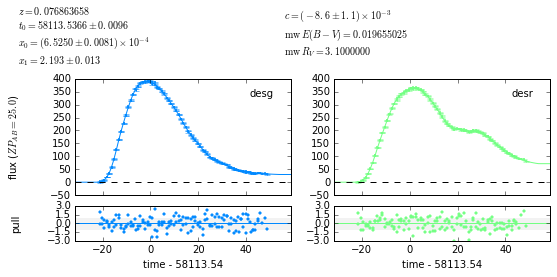

In [28]:
lc = lcs[32]

import sncosmo
survey.model.set(z=lc.meta['z'],mwebv=lc.meta['mwebv'])
res, fitted_model = sncosmo.fit_lc(lc, survey.model, ['t0', 'x0', 'x1', 'c'])

_ = sncosmo.plot_lc(lc, model=fitted_model, errors=res.errors)

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f75c766b290>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f75c767aed0>,
 'figure': <matplotlib.figure.Figure at 0x7f75c766b8d0>,
 'plot': <matplotlib.collections.PathCollection at 0x7f75c767a990>}

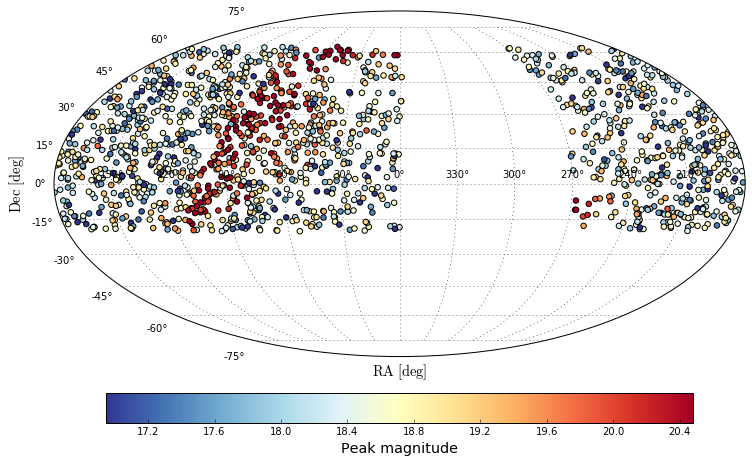

In [19]:
# MW E(B-V) is now automatically included in the lc model,
# so MW can be seen in magnitudes
peak_mag = survey.get_bandmag(band='bessellr', magsys='vega', t=0) # t is time relative to t0
survey.generator.show_skycoverage(cscale=peak_mag, cblabel="Peak magnitude", mask=(n_obs > 0))

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f75c78f1810>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f75c799da50>,
 'figure': <matplotlib.figure.Figure at 0x7f75d064e090>,
 'plot': <matplotlib.collections.PathCollection at 0x7f75c79ae790>}

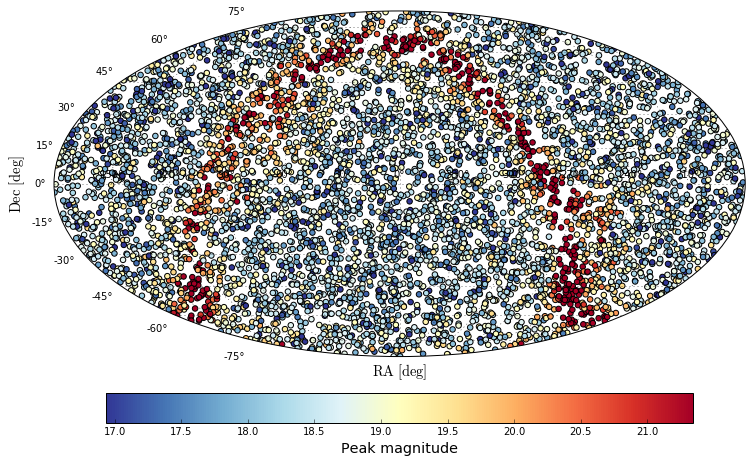

In [20]:
# It's more obvious when using the whole sample
survey.generator.show_skycoverage(cscale=peak_mag, cblabel="Peak magnitude")